### Set up

In [ ]:
# IMPORT PACKAGES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re 
import pickle as pkl
import mne
import copy as copy
from pathlib import Path
import csv
from mne.time_frequency import psd_array_welch

In [ ]:
# DEFINE PATHS

# USER INPUT
subject = "NVAR001"
run = "rest2"


# Folder names
session = subject + "_" + run
base_dir = "C:/meg/NVAR_sprint_fooof"
output_dir = os.path.join(base_dir, "output", session)
og_dir = os.path.join(output_dir, "og")
ref_dir = os.path.join(output_dir, "reformatted")
ref_stc_dir = os.path.join(output_dir, "reformatted_stc")
ref_stc_params_dir = os.path.join(output_dir, "reformatted_stc_params")
input_dir = os.path.join(base_dir, "input")

# File names, may be helpful later
stc_name = "sub_" + session + "_raw_tsss_beamformer_stc"
stc_path = os.path.join(input_dir, stc_name)
sprint_path = os.path.join(og_dir, "sprint_output.pkl")

In [5]:
# IF NEEDED, LOAD ORIGINAL STC

# Load stc for this subject
stc = mne.read_source_estimate(stc_path)

### og psd
Original psd (no sprint) on original data for the sake of later comparison

In [ ]:
psd, freqs = psd_array_welch(
    stc.data,
    sfreq=1000,
    fmin=0,
    fmax=500 / 2,
    n_per_seg=1024
)

stc_psd = mne.SourceEstimate(
    psd,
    vertices=stc.vertices,
    tmin=freqs[0],
    tstep=freqs[1] - freqs[0],
    subject=stc.subject
)

brain = stc_psd.copy().crop(tmin=0, tmax=40).plot(
    subject='sub_' + subject, 
    subjects_dir="C:/meg/NVAR_sprint_fooof/MRI/freesurfer/", 
    initial_time=0, 
    hemi='both'
    )

Effective window size : 0.256 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.7s finished


Using pyvistaqt 3d backend.
Using control points [0.18554248 0.20755778 0.36199351]
False


### Reformat output

In [ ]:
# REFORMAT FOOOF CSVS 

# I coded sprint kind of incorrectly, where the output is appended with the vertex index rather than the vertex number itself. 
# (that's why in the output dir the vertices go 0, 1, ..., n even though we all know stc files could never)
# So here I have to work with vertex index. Output will be appended with actual vertex number
# such that the problem is fixed in the _reformatted stage

def reformat(csv_prefix):
    for time_window in range(55):
        rows = []

        for data_index in range(len(stc.data)):

            og_csv_path = f"{og_dir}/{csv_prefix}_vertex_{data_index}.csv"
            og_df = pd.read_csv(og_csv_path)

            row = og_df.iloc[time_window].copy()
            row['vertex_index'] = data_index
            rows.append(row)

        pd.DataFrame(rows).to_csv(f"{ref_dir}/{csv_prefix}_window_{time_window}.csv", index=False)

reformat("foof_" + stc_name)

### View parameterization result

In [ ]:
# CREATE STCS WITH PARAMETER VALUES
# I want a [beta_pw, exponent, offset, model error] at each time window/csv

for keyword in ["beta_pw", "exponent", "offset", "error"]: 

    # Initialize array
    new_data = np.zeros(shape = (8196, 55))
    new_times = np.zeros(shape = (55, ))

    # Loop through time windows
    for window_num in range(55): 
        window_file = pd.read_csv(f"{ref_dir}/foof_{stc_name}_window_{window_num}.csv")
        
        measure = window_file[keyword].to_numpy().reshape(-1, 1)
        measure[np.isnan(measure)] = 0

        new_data[:, window_num] = measure[:, 0]
        new_times[window_num] = window_num

    # Write to stc
    new_stc = mne.SourceEstimate(
        data=new_data, 
        vertices=stc.vertices,
        tmin=0, 
        tstep=1
        )
    new_stc.save(os.path.join(ref_stc_params_dir, keyword), overwrite=True)

    # brain = new_stc.plot(
    #     subject='sub_' + subject, 
    #     subjects_dir="C:/meg/NVAR_sprint_fooof/MRI/freesurfer/", 
    #     initial_time=0, 
    #     hemi='both'
    # )


### View SPRINT result

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

with open("C:/meg/NVAR_sprint_fooof/output_NVAR001_rest1_4s_v2/sprint_output.pkl", "rb") as f:
    sprint_output = pickle.load(f)

{'TF': array([[[6.21879297e-04, 1.39648747e-02, 5.05776073e-02, ...,
          1.12142466e-08, 6.42792594e-09, 4.49456640e-09],
         [3.95679739e-03, 2.94330230e-02, 6.53412457e-02, ...,
          1.16248687e-08, 7.08001993e-09, 5.56079475e-09],
         [3.69637728e-03, 3.23922032e-02, 6.39399850e-02, ...,
          7.94635091e-09, 6.63258047e-09, 5.50748058e-09],
         ...,
         [1.15178098e-03, 1.44742898e-02, 6.45003086e-02, ...,
          2.56024870e-08, 1.35438361e-08, 2.26544580e-09],
         [3.25720504e-03, 2.08154392e-02, 6.61461914e-02, ...,
          2.40994488e-08, 1.69575852e-08, 3.61364093e-09],
         [4.00520070e-03, 2.31563080e-02, 6.72368367e-02, ...,
          2.16928189e-08, 2.16096803e-08, 9.51607931e-09]],
 
        [[1.39799549e-03, 5.36427774e-03, 4.39204893e-02, ...,
          1.77258359e-08, 2.41551194e-08, 1.41785194e-08],
         [1.83844414e-03, 1.05958681e-02, 5.10516876e-02, ...,
          1.69194911e-08, 2.47151290e-08, 1.45599510e-08],
 

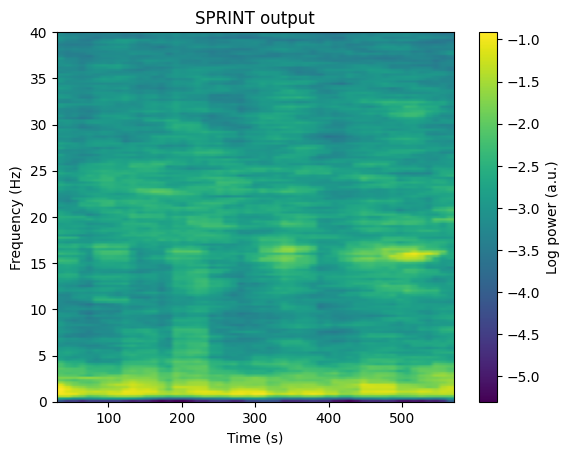

In [145]:
# PSD FROM SPRINT

# Read pickle
with open(sprint_path, "rb") as f:
    sprint_output = pickle.load(f)

"""
{'TF': array([[[3.31908108e-03, 1.02582303e-02, 8.88306617e-02, ...,
          9.70627037e-09, 1.11829197e-08, 5.25525509e-09],
         [2.96408614e-03, 1.69900910e-02, 7.49004008e-02, ...,
          7.25223534e-09, 5.75652586e-09, 2.79190429e-09],
         [9.34263580e-03, 3.87811856e-02, 1.28666873e-01, ...,
          2.81715080e-08, 1.46847533e-08, 8.24747301e-09],
         [1.95411091e-02, 9.29586804e-02, 2.41253203e-01, ...,
          2.65038759e-08, 1.45788630e-08, 1.04515533e-08]]],
       shape=(8196, 55, 2001)),
 'freqs': array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 4.9950e+02, 4.9975e+02,
        5.0000e+02], shape=(2001,)),
 'ts': array([ 30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130.,
        140., 150., 160., 170., 180., 190., 200., 210., 220., 230., 240.,
        250., 260., 270., 280., 290., 300., 310., 320., 330., 340., 350.,
        360., 370., 380., 390., 400., 410., 420., 430., 440., 450., 460.,
        470., 480., 490., 500., 510., 520., 530., 540., 550., 560., 570.]),
 'options': {'sfreq': 1000,
  'WinLength': 4,
  'WinOverlap': 50,
  'WinAverage': 5,
  'rmoutliers': 1,
  'maxTime': 6,
  'maxFreq': 2.5,
  'minNear': 3}}

"""

# Plot one for each timepoint
# for NVAR001_rest1 sprint_output is the TF array directly; for the rest you need to extract
TF = sprint_output["TF"]
freqs = sprint_output["freqs"]
ts = sprint_output["ts"]
# Crop frequency width
TF_cropped = TF[:, :, :161]
freqs = freqs[:161]
# First take the mean
TF_wb_mean = TF_cropped.mean(axis=0)
# Take log
TF_log = np.log(TF_wb_mean)

plt.imshow(
    TF_log.T,
    aspect="auto",
    origin="lower",
    extent=[ts[0], ts[-1], freqs[0], freqs[-1]]
)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Log power (a.u.)")
plt.title("SPRINT output")
plt.show()

Text(0.5, 1.0, 'SPRINT output \n colored by time window')

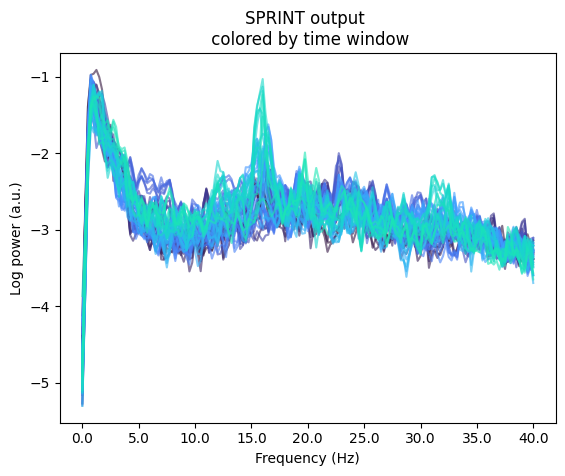

In [146]:
# PSD FOR EACH TIME
colors = plt.cm.turbo(np.linspace(0, 1, 161))
# Loop through times
for i in range(len(TF_log)):
    plt.plot(TF_log[i], color=colors[i], alpha=0.6)
plt.xticks(np.arange(0, 161, 20), freqs[np.arange(0, 161, 20)])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log power (a.u.)")
plt.title("SPRINT output \n colored by time window")

In [ ]:
# CREATE INDIVIDUAL STCS
# One stc for each time window
# You should have 55 stcs, and each is PSD vs freq

# Do not log it
# Starts at 2 because I noticed during whitening the model fit worse there
# Ends at 161 because that's 40 Hz
TF_cropped = TF[:, :, 2:161]

for j in range(TF_cropped.shape[1]): 
    slice_j = TF_cropped[:, j, :]
    new_stc = mne.SourceEstimate(
        data = slice_j, 
        vertices = stc.vertices, 
        tmin = 0.5, 
        tstep = 0.25
    )
    new_stc.save(os.path.join(ref_stc_dir, str(j)), overwrite=True)

# Check: plot each one
stc_check = mne.read_source_estimate(os.path.join(ref_stc_dir, str(49)))
plt.plot(np.arange(0, 200), stc_check.data.mean(axis = 0))

### Whitening

In [ ]:
# SUBTRACTION
# Do one window at a time
# input is stc in reformatted_stcs folder (psd, not yet logged) and window-formatted csv fooof output
# Output is _whitened.stc, saved in reformatted_stcs folder

# Frequency dimension: Goal is to match the dimension of the stc frequency array, which is:
freq_dim = freqs[2:161]

for window_num in range(55): 
    print(str(window_num))

    ##### Prep

    # Load files that you will need
    current_stc = os.path.join(ref_stc_dir, str(window_num))
    stc = mne.read_source_estimate(current_stc)
    current_csv = os.path.join(ref_dir, "foof_sub_" + session + "_raw_tsss_beamformer_stc_window_" + str(window_num) + ".csv")
    csv = pd.read_csv(current_csv)


    ##### PSD Model (exponential)

    # This is the list where you will put the model for each vertex
    rows = []

    # Get average offset and exponent for this subject (to be used for fixing bad values)
    average_exponent = np.nanmean(csv.iloc[:, 2])
    average_offset = np.nanmean(csv.iloc[:, 1])

    # Loop through rows of csv file
    for i in range(len(csv)): 
        
        # Collect values
        vertex = int(csv.iloc[i, 0])
        exponent = csv.iloc[i, 2]
        offset = csv.iloc[i, 1]

        # Make sure values look okay; if there are errors, replace with subject mean
        if type(exponent) != np.float64 or not np.isfinite(exponent): 
            print("error in exponent for subject " + subject + " vertex " + str(vertex) + ", setting to subject average")
            exponent = average_exponent
        if type(offset) != np.float64 or not np.isfinite(offset): 
            print("error in offset for subject " + subject + " vertex " + str(vertex) + ", setting to subject average")
            offset = average_offset

        # Compute exponential for this vertex
        # In linear space - not in log space
        exponential = 10**(offset - (np.log10(freq_dim))*exponent)
    #   print(exponential)
    #   print(freq_dim[0, 0])
    #   print(offset)
    #   print(exponent)

        # Add the exponential for this vertex to the "rows" list
        rows.append(exponential)

    # The final array of all exponentials for all vertices (cleaned up)
    model = np.array(rows).squeeze()

    ##### Subtraction

    # Whiten PSD: Subtract model PSD from real PSD
    # model: comes in not logged (linear)
    # stc data: comes in not logged (linear)
    # frequency is linear for both
    # subtraction happens in linear-linear space
    whitened_psd = stc.data - model

    # Create a plot for whitened PSD, and save it for review
    plt.figure()
    plt.plot(freq_dim, np.average(model.T, axis=1), label="Aperiodic fit", color="blue")
    plt.plot(stc.times, np.average(stc.data.T, axis=1), label="Original PSD", color="black")
    plt.plot(freq_dim, np.average(whitened_psd.T, axis=1), label="Whitened PSD", color="red")
    plt.ylabel("Power")
    plt.xlabel("Frequency")
    plt.legend()
    plt.title("Window " + str(window_num) + " detrending")
    plt.savefig(os.path.join(output_dir, "Images/Subtraction", str(window_num) + "_whitened.png"), dpi=300, bbox_inches="tight") 
    plt.close()

    # Convert the whitened psd to stc, then save it
    whitened_psd_stc = mne.SourceEstimate(
        data=whitened_psd,
        vertices=stc.vertices,
        tmin=0, 
        tstep=0.25
        )
    whitened_psd_stc.save(os.path.join(ref_stc_dir, str(window_num) + "_whitened"), overwrite=True)

In [36]:
# BREAK WHITENED STCS INTO FREQUENCY BANDS

bands = {'delta' : [1, 4], 'theta' : [4, 7], 'alpha' : [8, 12], 'beta' : [15, 29], 'low_gamma' : [30, 40]}

for band in bands: 

    low = bands[band][0]
    high = bands[band][1]

    new_data = np.zeros(shape = (8196, 55))

    # Loop through time windows
    for window_num in range(55): 

        path = os.path.join(ref_stc_dir, str(window_num) + "_whitened")
        stc = mne.read_source_estimate(path)

        trimmed_data = stc.data[:, (stc.times <= high) & (stc.times >= low)]
        average_in_this_window = trimmed_data.mean(axis=1) # Compute average across all freqs

        new_data[:, window_num] = average_in_this_window

    new_stc = mne.SourceEstimate(
        data=new_data, 
        vertices=stc.vertices,
        tmin=0, 
        tstep=1
        )
    
    save_path = os.path.join(ref_stc_dir, band)
    print(save_path)
    new_stc.save(save_path, overwrite=True)



C:/meg/NVAR_sprint_fooof\output\NVAR001_rest2\reformatted_stc\delta
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
C:/meg/NVAR_sprint_fooof\output\NVAR001_rest2\reformatted_stc\theta
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
C:/meg/NVAR_sprint_fooof\output\NVAR001_rest2\reformatted_stc\alpha
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
C:/meg/NVAR_sprint_fooof\output\NVAR001_rest2\reformatted_stc\beta
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
C:/meg/NVAR_sprint_fooof\output\NVAR001_rest2\reformatted_stc\low_gamma
Writing STC to disk...
[done]


In [141]:
band_stc = mne.read_source_estimate("C:/meg/NVAR_sprint_fooof/output/NVAR001_rest2/reformatted_stc_params/offset")

brain = band_stc.plot(
    subject='sub_' + subject, 
    subjects_dir="C:/meg/NVAR_sprint_fooof/MRI/freesurfer/", 
    initial_time=5*0, 
    hemi='both', 
    time_viewer = False
)
brain.show_view('dorsal') 

Using control points [1.46319785 1.53684629 2.05077447]
False


### Butterfly plots by region

Reading labels from parcellation...
   read 51 labels from C:\meg\NVAR_sprint_fooof\MRI\freesurfer\sub_NVAR001\label\lh.Schaefer2018_100.annot
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
Extracting time courses for 51 labels (mode: pca_flip)


C:\Users\Isabel\AppData\Local\Temp\ipykernel_10124\3155172368.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", n_labels)


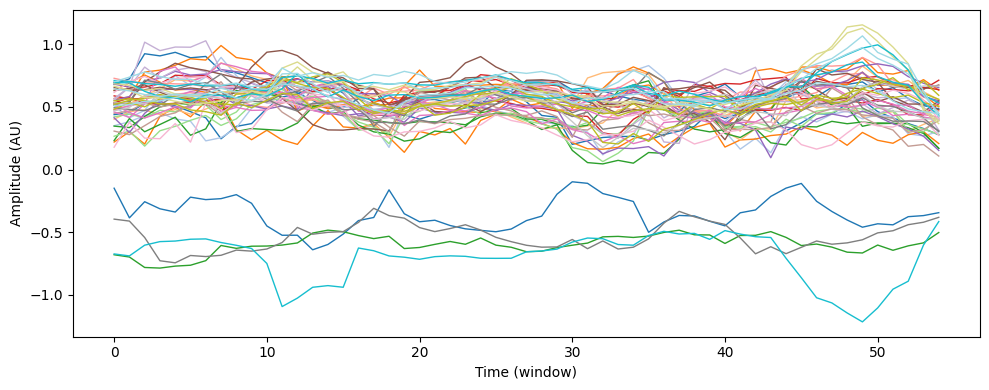

Using control points [0.8801147  0.92819977 1.28779847]
False


In [ ]:
labels = mne.read_labels_from_annot(
    subject = "sub_" + subject,
    hemi = "lh",
    parc = "Schaefer2018_100", 
    subjects_dir = "C:/meg/NVAR_sprint_fooof/MRI/freesurfer"
    )

#"C:/meg/NVAR_sprint_fooof/output/NVAR001_rest2/reformatted_stc_params/beta_pw"
stcs = mne.read_source_estimate("C:/meg/NVAR_sprint_fooof/output/NVAR001_rest2/reformatted_stc_params/exponent")
src = mne.read_source_spaces(os.path.join(input_dir, "sub_NVAR001_rest2_raw_tsss_src.fif"))

multiseries = mne.extract_label_time_course(stcs = stcs, src = src, labels = labels, mode = "pca_flip")

n_labels = len(labels)

# pick a colormap and sample it evenly
import matplotlib.cm as cm
cmap = cm.get_cmap("tab20", n_labels)
colors = [cmap(i) for i in range(n_labels)]

# plot time series
plt.figure(figsize=(10, 4))
for i in range(n_labels):
    plt.plot(stcs.times, multiseries[i], color=colors[i], linewidth=1)

plt.xlabel("Time (window)")
plt.ylabel("Amplitude (AU)")
plt.tight_layout()
plt.show()

brain = stcs.plot(
    subject='sub_' + subject, 
    subjects_dir="C:/meg/NVAR_sprint_fooof/MRI/freesurfer/", 
    initial_time=0, 
    hemi='both'
)


In [73]:
from mne.viz import Brain

brain = Brain(
    subject="sub_" + subject,
    hemi="rh",
    surf="inflated",
    subjects_dir="C:/meg/NVAR_sprint_fooof/MRI/freesurfer",
    background="white"
)

for label, color in zip(labels, colors):
    brain.add_label(label, color=color, alpha=0.9)

False


In [85]:
path = "C:/meg/NVAR_sprint_fooof/output/NVAR001_rest2/reformatted"

offset_series = pd.Series(name = "offset")
exponent_series = pd.Series(name = "exponent")
vertex_series = pd.Series(name = "vertex")
window_series = pd.Series(name = "window")

for window in range(55): 
    csv_path = os.path.join(path, "foof_sub_NVAR001_rest2_raw_tsss_beamformer_stc_window_" + str(window) + ".csv")
    csv = pd.read_csv(csv_path)

    # Extract info
    offset = csv["offset"]
    exponent = csv["exponent"]
    vertex_index = csv["vertex_index"]
    rep_window = [window]*8196
    rep_window_series = pd.Series(rep_window)

    # Add to series
    offset_series = pd.concat([offset_series, offset])
    exponent_series = pd.concat([exponent_series, exponent])
    vertex_series = pd.concat([vertex_series, vertex_index])
    window_series = pd.concat([window_series, rep_window_series])

# Put all the series together
df = pd.concat([offset_series, exponent_series, vertex_series, window_series], axis=1)
df.to_csv(os.path.join(path, "summary.csv"), index=False)